In [40]:
import torch
import torch.nn as nn
import torch.optim as optim

class TwoPartNetwork(nn.Module):
    def __init__(self):
        super(TwoPartNetwork, self).__init__()
        self.part1 = nn.Linear(10, 20)
        self.part2 = nn.Linear(20, 1)

    def forward(self, x):
        x = self.part1(x)
        x = torch.relu(x)
        x = self.part2(x)
        return x


import torch.optim as optim

import torch.optim as optim

class AlterOptimizer(optim.Optimizer):
    def __init__(self, params_list, lr_list, alternate=True):
        assert len(params_list) == len(lr_list), "每组参数必须有对应的学习率"
        
        # 初始化基类
        optimizers_params = []
        for params, lr in zip(params_list, lr_list):
            optimizers_params.append({'params': params, 'lr': lr})
        super(AlterOptimizer, self).__init__(optimizers_params, {})

        self.optimizers = [
            optim.Adam(group['params'], lr=group['lr']) for group in self.param_groups
        ]
        self.alternate = alternate
        self.current_opt_index = 0  # 当前优化器的索引

    def step(self, closure=None):
        # 如果设置为轮流优化，则每次只更新当前优化器
        if self.alternate:
            loss = None
            if closure is not None:
                loss = closure()
            self.optimizers[self.current_opt_index].step()
            # 更新当前优化器索引，循环到下一个
            self.current_opt_index = (self.current_opt_index + 1) % len(self.optimizers)
            return loss
        else:
            # 同时更新所有优化器
            for optimizer in self.optimizers:
                optimizer.step()

    def zero_grad(self, set_to_none=False):
        for optimizer in self.optimizers:
            optimizer.zero_grad(set_to_none=set_to_none)



# 假设输入和目标数据
input = torch.randn(5, 10)
target = torch.randn(5, 1)

# 损失函数
loss_function = nn.MSELoss()

In [43]:
model = TwoPartNetwork()

custom_optimizer = AlterOptimizer(
    [model.part1.parameters(), model.part2.parameters()], 
    [0.01, 0.001],
    alternate=True  # 可以设置为 False 以同时优化两部分参数
)

scheduler = optim.lr_scheduler.StepLR(custom_optimizer, step_size=30, gamma=0.1)
num_epochs = 100
L1 = []
for epoch in range(num_epochs):
    custom_optimizer.zero_grad()
    
    output = model(input)
    loss = loss_function(output, target)

    loss.backward()
    custom_optimizer.step()
    scheduler.step()
    L1.append(loss.item())

In [44]:
model = TwoPartNetwork()

custom_optimizer = AlterOptimizer(
    [model.part1.parameters(), model.part2.parameters()], 
    [0.01, 0.001],
    alternate=False  # 可以设置为 False 以同时优化两部分参数
)
scheduler = optim.lr_scheduler.StepLR(custom_optimizer, step_size=30, gamma=0.1)
num_epochs = 100
L2 = []
for epoch in range(num_epochs):
    custom_optimizer.zero_grad()
    
    output = model(input)
    loss = loss_function(output, target)

    loss.backward()
    custom_optimizer.step()
    scheduler.step()
    L2.append(loss.item())

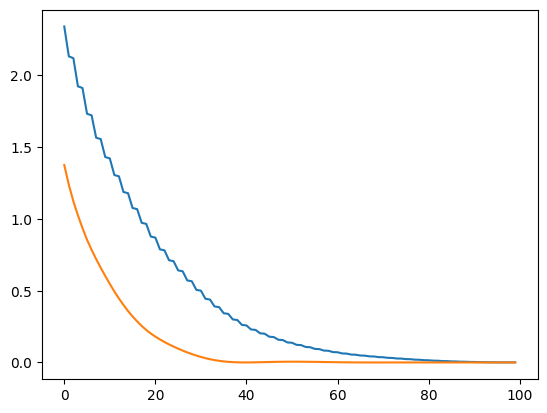

In [45]:
import matplotlib.pyplot as plt

plt.plot(L1, label='Alternate')
plt.plot(L2, label='Simultaneous')